In [32]:
# coding: utf-8

# In[7]:

import sys,os
import numpy as np
import dicom
import glob
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
from sklearn import cross_validation
from lightgbm.sklearn import LGBMRegressor
from Vgg19 import VGG19
from keras.preprocessing import image

In [33]:
import errno
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
EXPERIMENT_NUMBER = 'vgg19' 

#Put here the path where you downloaded all kaggle data
DATA_PATH='data/'

# Path and variables
STAGE1_LABELS=DATA_PATH + 'stage1_labels.csv'
STAGE1_SAMPLE_SUBMISSION=DATA_PATH + 'stage1_sample_submission.csv'
STAGE1_FOLDER=DATA_PATH + 'stage1/'
FEATURE_FOLDER=DATA_PATH + 'features/features' + EXPERIMENT_NUMBER + '/'
SUBMIT_OUTPUT='submit' + EXPERIMENT_NUMBER + '_label_image.csv'

STAGE1_SAMPLE_SUBMISSION_2=DATA_PATH + 'stage1_sample_avg_submission.csv'
SUBMIT_OUTPUT_2='submit' + EXPERIMENT_NUMBER + '_label_image_Avg.csv'
SUBMIT_OUTPUT_3='submit' + EXPERIMENT_NUMBER + '_label_image_Max.csv'
SUBMIT_OUTPUT_4='submit' + EXPERIMENT_NUMBER + '_label_image_Min.csv'

make_sure_path_exists(FEATURE_FOLDER)

In [16]:
# Timer class
class Timer(object):
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        self.start = time.clock()

    def stop(self):
        self.end = time.clock()
        self.interval = self.end - self.start


In [17]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [18]:
def get_data_id(path, plot_data=False):
    sample_image = get_3d_data(path)
    sample_image[sample_image == -2000] = 0
    #if plot_data:
    #    f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))

    batch = []
    cnt = 0
    dx = 40
    ds = 512
    for i in range(0, sample_image.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = sample_image[i + j]
            img = 255.0 / np.amax(img) * img
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img.astype(np.uint8)
            img = img[dx: ds - dx, dx: ds - dx]
            img = cv2.resize(img, (224, 224))
            tmp.append(img)

        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2) #we need to make "color" dimension last I think
        batch.append(np.array(tmp))
        
    batch = np.array(batch, dtype='int')
    return batch



In [19]:
def get_model():
    model = VGG19(weights='imagenet', include_top=False)
    return model

In [20]:
def calc_features(verbose=False):
    model = get_model()
    for folder in glob.glob(STAGE1_FOLDER+'*'):
        foldername = os.path.basename(folder)
        if os.path.isfile(FEATURE_FOLDER+foldername+'.npy'):
            if verbose: print("Features in %s already computed" % (FEATURE_FOLDER+foldername))
            continue
        batch = get_data_id(folder)
        if verbose:
            print("Batch size:")
            print(batch.shape)
        feats = model.predict(batch, batch_size=52, verbose=1)

        if verbose:
            print(feats.shape)
            print("Saving features in %s" % (FEATURE_FOLDER+foldername))
        np.save(FEATURE_FOLDER+foldername, feats)

In [8]:
        
#%%time
# Calculate features
calc_features(verbose=False)

In [21]:
# In[25]:
global x
global y
def train_lightgbm():
    df = pd.read_csv(STAGE1_LABELS)
    image_num = 0
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
#         print 'load_one shape: ', load_one.shape (1,64,7,7,512)
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
#         print 'load one shape', load_one.shape
#         print 'x shape:', x.shape
        image_num += b
#         print 'lenght of df before', len(df_2)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num
#         print 'length of df_2', len(df_2[:i])
    y = np.array(df_2)
    print 'x.shape', x.shape
    print 'y.shape', y.shape
    
    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
                                                                   test_size=0.20)
    clf = LGBMRegressor(max_depth=50,
                        num_leaves=21,
                        n_estimators=5000,
                        min_child_weight=1,
                        learning_rate=0.001,
                        nthread=24,
                        subsample=0.80,
                        colsample_bytree=0.80,
                        seed=42)
    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=True, eval_metric='l2', early_stopping_rounds=900)
    return clf

In [22]:
def compute_training(verbose=True):
    with Timer() as t:
        clf = train_lightgbm()
    if verbose: print("Training took %.03f sec.\n" % t.interval)
    return clf

In [23]:
def compute_prediction(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION)
    x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    # use global df and x
    #global x
    
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    # calculate accuracy
    print pred
    
    df['cancer'] = pred
    return df

In [24]:
def save_results(df):
    df.to_csv(SUBMIT_OUTPUT, index=False)

In [ ]:
clf = compute_training(verbose=True)

length of df_2 1397
x.shape (81942, 25088)
y.shape (81942,)
[1]	valid_0's l2: 0.523421
Train until valid scores didn't improve in 900 rounds.
[2]	valid_0's l2: 0.523249
[3]	valid_0's l2: 0.52308
[4]	valid_0's l2: 0.522913
[5]	valid_0's l2: 0.522745
[6]	valid_0's l2: 0.522578
[7]	valid_0's l2: 0.522407
[8]	valid_0's l2: 0.522236
[9]	valid_0's l2: 0.522068
[10]	valid_0's l2: 0.521899
[11]	valid_0's l2: 0.52173
[12]	valid_0's l2: 0.521562
[13]	valid_0's l2: 0.521395
[14]	valid_0's l2: 0.52123
[15]	valid_0's l2: 0.521065
[16]	valid_0's l2: 0.5209
[17]	valid_0's l2: 0.520733
[18]	valid_0's l2: 0.52057
[19]	valid_0's l2: 0.520403
[20]	valid_0's l2: 0.520238
[21]	valid_0's l2: 0.520073
[22]	valid_0's l2: 0.519909
[23]	valid_0's l2: 0.519744
[24]	valid_0's l2: 0.51958
[25]	valid_0's l2: 0.519417
[26]	valid_0's l2: 0.519253
[27]	valid_0's l2: 0.519088
[28]	valid_0's l2: 0.518923
[29]	valid_0's l2: 0.518763
[30]	valid_0's l2: 0.518602
[31]	valid_0's l2: 0.51844
[32]	valid_0's l2: 0.518277
[33]	v

[285]	valid_0's l2: 0.484711
[286]	valid_0's l2: 0.484605
[287]	valid_0's l2: 0.484499
[288]	valid_0's l2: 0.484393
[289]	valid_0's l2: 0.484287
[290]	valid_0's l2: 0.484177
[291]	valid_0's l2: 0.484074
[292]	valid_0's l2: 0.48397
[293]	valid_0's l2: 0.483865
[294]	valid_0's l2: 0.483761
[295]	valid_0's l2: 0.483657
[296]	valid_0's l2: 0.483551
[297]	valid_0's l2: 0.483446
[298]	valid_0's l2: 0.483343
[299]	valid_0's l2: 0.483234
[300]	valid_0's l2: 0.483129
[301]	valid_0's l2: 0.483025
[302]	valid_0's l2: 0.482918
[303]	valid_0's l2: 0.482815
[304]	valid_0's l2: 0.48271
[305]	valid_0's l2: 0.482605
[306]	valid_0's l2: 0.482502
[307]	valid_0's l2: 0.4824
[308]	valid_0's l2: 0.482295
[309]	valid_0's l2: 0.482191
[310]	valid_0's l2: 0.482088
[311]	valid_0's l2: 0.481985
[312]	valid_0's l2: 0.481882
[313]	valid_0's l2: 0.481777
[314]	valid_0's l2: 0.481674
[315]	valid_0's l2: 0.481573
[316]	valid_0's l2: 0.481472
[317]	valid_0's l2: 0.481371
[318]	valid_0's l2: 0.481269
[319]	valid_0's l2

[569]	valid_0's l2: 0.46036
[570]	valid_0's l2: 0.46029
[571]	valid_0's l2: 0.460222
[572]	valid_0's l2: 0.460155
[573]	valid_0's l2: 0.460088
[574]	valid_0's l2: 0.460022
[575]	valid_0's l2: 0.459954
[576]	valid_0's l2: 0.459889
[577]	valid_0's l2: 0.459824
[578]	valid_0's l2: 0.459756
[579]	valid_0's l2: 0.45969
[580]	valid_0's l2: 0.459624
[581]	valid_0's l2: 0.459556
[582]	valid_0's l2: 0.45949
[583]	valid_0's l2: 0.459425
[584]	valid_0's l2: 0.459357
[585]	valid_0's l2: 0.459291
[586]	valid_0's l2: 0.459226
[587]	valid_0's l2: 0.459158
[588]	valid_0's l2: 0.459093
[589]	valid_0's l2: 0.459025
[590]	valid_0's l2: 0.45896
[591]	valid_0's l2: 0.458895
[592]	valid_0's l2: 0.45883
[593]	valid_0's l2: 0.458764
[594]	valid_0's l2: 0.4587
[595]	valid_0's l2: 0.458635
[596]	valid_0's l2: 0.458568
[597]	valid_0's l2: 0.458501
[598]	valid_0's l2: 0.458437
[599]	valid_0's l2: 0.458372
[600]	valid_0's l2: 0.458308
[601]	valid_0's l2: 0.458245
[602]	valid_0's l2: 0.458182
[603]	valid_0's l2: 0.

[853]	valid_0's l2: 0.444949
[854]	valid_0's l2: 0.444906
[855]	valid_0's l2: 0.444863
[856]	valid_0's l2: 0.444821
[857]	valid_0's l2: 0.444776
[858]	valid_0's l2: 0.444734
[859]	valid_0's l2: 0.444689
[860]	valid_0's l2: 0.444646
[861]	valid_0's l2: 0.444602
[862]	valid_0's l2: 0.444559
[863]	valid_0's l2: 0.444519
[864]	valid_0's l2: 0.444475
[865]	valid_0's l2: 0.444433
[866]	valid_0's l2: 0.44439
[867]	valid_0's l2: 0.444348
[868]	valid_0's l2: 0.444305
[869]	valid_0's l2: 0.444262
[870]	valid_0's l2: 0.44422
[871]	valid_0's l2: 0.444177
[872]	valid_0's l2: 0.444136
[873]	valid_0's l2: 0.444093
[874]	valid_0's l2: 0.444053
[875]	valid_0's l2: 0.444011
[876]	valid_0's l2: 0.44397
[877]	valid_0's l2: 0.443929
[878]	valid_0's l2: 0.443888
[879]	valid_0's l2: 0.443848
[880]	valid_0's l2: 0.443808
[881]	valid_0's l2: 0.443767
[882]	valid_0's l2: 0.443725
[883]	valid_0's l2: 0.443685
[884]	valid_0's l2: 0.443644
[885]	valid_0's l2: 0.443603
[886]	valid_0's l2: 0.443561
[887]	valid_0's l

[1132]	valid_0's l2: 0.435163
[1133]	valid_0's l2: 0.435136
[1134]	valid_0's l2: 0.435108
[1135]	valid_0's l2: 0.435081
[1136]	valid_0's l2: 0.435051
[1137]	valid_0's l2: 0.435025
[1138]	valid_0's l2: 0.434998
[1139]	valid_0's l2: 0.43497
[1140]	valid_0's l2: 0.434942
[1141]	valid_0's l2: 0.434913
[1142]	valid_0's l2: 0.434885
[1143]	valid_0's l2: 0.434856
[1144]	valid_0's l2: 0.434829
[1145]	valid_0's l2: 0.434802
[1146]	valid_0's l2: 0.434775
[1147]	valid_0's l2: 0.434751
[1148]	valid_0's l2: 0.434724
[1149]	valid_0's l2: 0.434696
[1150]	valid_0's l2: 0.434669
[1151]	valid_0's l2: 0.434642
[1152]	valid_0's l2: 0.434617
[1153]	valid_0's l2: 0.43459
[1154]	valid_0's l2: 0.434562
[1155]	valid_0's l2: 0.434537
[1156]	valid_0's l2: 0.434511
[1157]	valid_0's l2: 0.434482
[1158]	valid_0's l2: 0.434454
[1159]	valid_0's l2: 0.434427
[1160]	valid_0's l2: 0.4344
[1161]	valid_0's l2: 0.434373
[1162]	valid_0's l2: 0.434347
[1163]	valid_0's l2: 0.434319
[1164]	valid_0's l2: 0.434294
[1165]	valid_0

[1406]	valid_0's l2: 0.428758
[1407]	valid_0's l2: 0.428738
[1408]	valid_0's l2: 0.42872
[1409]	valid_0's l2: 0.4287
[1410]	valid_0's l2: 0.42868
[1411]	valid_0's l2: 0.428662
[1412]	valid_0's l2: 0.428643
[1413]	valid_0's l2: 0.428622
[1414]	valid_0's l2: 0.428604
[1415]	valid_0's l2: 0.428586
[1416]	valid_0's l2: 0.428568
[1417]	valid_0's l2: 0.428549
[1418]	valid_0's l2: 0.42853
[1419]	valid_0's l2: 0.428512
[1420]	valid_0's l2: 0.428494
[1421]	valid_0's l2: 0.428476
[1422]	valid_0's l2: 0.428455
[1423]	valid_0's l2: 0.428437
[1424]	valid_0's l2: 0.428419
[1425]	valid_0's l2: 0.4284
[1426]	valid_0's l2: 0.42838
[1427]	valid_0's l2: 0.428362
[1428]	valid_0's l2: 0.428343
[1429]	valid_0's l2: 0.428324
[1430]	valid_0's l2: 0.428305
[1431]	valid_0's l2: 0.428285
[1432]	valid_0's l2: 0.428266
[1433]	valid_0's l2: 0.428249
[1434]	valid_0's l2: 0.428231
[1435]	valid_0's l2: 0.428213
[1436]	valid_0's l2: 0.428195
[1437]	valid_0's l2: 0.428176
[1438]	valid_0's l2: 0.428157
[1439]	valid_0's l

[1681]	valid_0's l2: 0.424225
[1682]	valid_0's l2: 0.424211
[1683]	valid_0's l2: 0.424196
[1684]	valid_0's l2: 0.424179
[1685]	valid_0's l2: 0.424163
[1686]	valid_0's l2: 0.424148
[1687]	valid_0's l2: 0.424134
[1688]	valid_0's l2: 0.42412
[1689]	valid_0's l2: 0.424106
[1690]	valid_0's l2: 0.424092
[1691]	valid_0's l2: 0.424077
[1692]	valid_0's l2: 0.424062
[1693]	valid_0's l2: 0.424048
[1694]	valid_0's l2: 0.424033
[1695]	valid_0's l2: 0.42402
[1696]	valid_0's l2: 0.424005
[1697]	valid_0's l2: 0.423992
[1698]	valid_0's l2: 0.423977
[1699]	valid_0's l2: 0.423963
[1700]	valid_0's l2: 0.423948
[1701]	valid_0's l2: 0.423934
[1702]	valid_0's l2: 0.423922
[1703]	valid_0's l2: 0.423909
[1704]	valid_0's l2: 0.423894
[1705]	valid_0's l2: 0.42388
[1706]	valid_0's l2: 0.423866
[1707]	valid_0's l2: 0.423854
[1708]	valid_0's l2: 0.423841
[1709]	valid_0's l2: 0.423827
[1710]	valid_0's l2: 0.423814
[1711]	valid_0's l2: 0.423799
[1712]	valid_0's l2: 0.423787
[1713]	valid_0's l2: 0.423774
[1714]	valid_

[1955]	valid_0's l2: 0.420872
[1956]	valid_0's l2: 0.420862
[1957]	valid_0's l2: 0.42085
[1958]	valid_0's l2: 0.42084
[1959]	valid_0's l2: 0.420829
[1960]	valid_0's l2: 0.420819
[1961]	valid_0's l2: 0.420807
[1962]	valid_0's l2: 0.420796
[1963]	valid_0's l2: 0.420785
[1964]	valid_0's l2: 0.420774
[1965]	valid_0's l2: 0.420764
[1966]	valid_0's l2: 0.420754
[1967]	valid_0's l2: 0.420742
[1968]	valid_0's l2: 0.420732
[1969]	valid_0's l2: 0.420723
[1970]	valid_0's l2: 0.420713
[1971]	valid_0's l2: 0.420702
[1972]	valid_0's l2: 0.420692
[1973]	valid_0's l2: 0.42068
[1974]	valid_0's l2: 0.420671
[1975]	valid_0's l2: 0.420662
[1976]	valid_0's l2: 0.420651
[1977]	valid_0's l2: 0.42064
[1978]	valid_0's l2: 0.420629
[1979]	valid_0's l2: 0.420618
[1980]	valid_0's l2: 0.420606
[1981]	valid_0's l2: 0.420595
[1982]	valid_0's l2: 0.420584
[1983]	valid_0's l2: 0.420575
[1984]	valid_0's l2: 0.420564
[1985]	valid_0's l2: 0.420554
[1986]	valid_0's l2: 0.420542
[1987]	valid_0's l2: 0.420533
[1988]	valid_0

[3505]	valid_0's l2: 0.40973
[3506]	valid_0's l2: 0.409725
[3507]	valid_0's l2: 0.409719
[3508]	valid_0's l2: 0.409714
[3509]	valid_0's l2: 0.409709
[3510]	valid_0's l2: 0.409702
[3511]	valid_0's l2: 0.409698
[3512]	valid_0's l2: 0.409692
[3513]	valid_0's l2: 0.409687
[3514]	valid_0's l2: 0.409681
[3515]	valid_0's l2: 0.409674
[3516]	valid_0's l2: 0.409668
[3517]	valid_0's l2: 0.409662
[3518]	valid_0's l2: 0.409656
[3519]	valid_0's l2: 0.40965
[3520]	valid_0's l2: 0.409642
[3521]	valid_0's l2: 0.409638
[3522]	valid_0's l2: 0.409633
[3523]	valid_0's l2: 0.409627
[3524]	valid_0's l2: 0.409621
[3525]	valid_0's l2: 0.409616
[3526]	valid_0's l2: 0.40961
[3527]	valid_0's l2: 0.409603
[3528]	valid_0's l2: 0.409598
[3529]	valid_0's l2: 0.409592
[3530]	valid_0's l2: 0.409586
[3531]	valid_0's l2: 0.409581
[3532]	valid_0's l2: 0.409575
[3533]	valid_0's l2: 0.409571
[3534]	valid_0's l2: 0.409566
[3535]	valid_0's l2: 0.409561
[3536]	valid_0's l2: 0.409556
[3537]	valid_0's l2: 0.409549
[3538]	valid_

[3780]	valid_0's l2: 0.40828
[3781]	valid_0's l2: 0.408274
[3782]	valid_0's l2: 0.408268
[3783]	valid_0's l2: 0.408262
[3784]	valid_0's l2: 0.408254
[3785]	valid_0's l2: 0.40825
[3786]	valid_0's l2: 0.408244
[3787]	valid_0's l2: 0.40824
[3788]	valid_0's l2: 0.408234
[3789]	valid_0's l2: 0.40823
[3790]	valid_0's l2: 0.408225
[3791]	valid_0's l2: 0.40822
[3792]	valid_0's l2: 0.408215
[3793]	valid_0's l2: 0.408209
[3794]	valid_0's l2: 0.408206
[3795]	valid_0's l2: 0.4082
[3796]	valid_0's l2: 0.408195
[3797]	valid_0's l2: 0.408189
[3798]	valid_0's l2: 0.408184
[3799]	valid_0's l2: 0.408179
[3800]	valid_0's l2: 0.408175
[3801]	valid_0's l2: 0.408169
[3802]	valid_0's l2: 0.408163
[3803]	valid_0's l2: 0.408157
[3804]	valid_0's l2: 0.408153
[3805]	valid_0's l2: 0.408148
[3806]	valid_0's l2: 0.408143
[3807]	valid_0's l2: 0.408138
[3808]	valid_0's l2: 0.408133
[3809]	valid_0's l2: 0.408128
[3810]	valid_0's l2: 0.408122
[3811]	valid_0's l2: 0.408117
[3812]	valid_0's l2: 0.408112
[3813]	valid_0's 

[4055]	valid_0's l2: 0.406914
[4056]	valid_0's l2: 0.406909
[4057]	valid_0's l2: 0.406905
[4058]	valid_0's l2: 0.406901
[4059]	valid_0's l2: 0.406895
[4060]	valid_0's l2: 0.40689
[4061]	valid_0's l2: 0.406886
[4062]	valid_0's l2: 0.40688
[4063]	valid_0's l2: 0.406875
[4064]	valid_0's l2: 0.406871
[4065]	valid_0's l2: 0.406866
[4066]	valid_0's l2: 0.406861
[4067]	valid_0's l2: 0.406854
[4068]	valid_0's l2: 0.40685
[4069]	valid_0's l2: 0.406845
[4070]	valid_0's l2: 0.40684
[4071]	valid_0's l2: 0.406836
[4072]	valid_0's l2: 0.406832
[4073]	valid_0's l2: 0.406827
[4074]	valid_0's l2: 0.406822
[4075]	valid_0's l2: 0.406817
[4076]	valid_0's l2: 0.406812
[4077]	valid_0's l2: 0.406808
[4078]	valid_0's l2: 0.406801
[4079]	valid_0's l2: 0.406796
[4080]	valid_0's l2: 0.40679
[4081]	valid_0's l2: 0.406786
[4082]	valid_0's l2: 0.406782
[4083]	valid_0's l2: 0.406778
[4084]	valid_0's l2: 0.406773
[4085]	valid_0's l2: 0.406769
[4086]	valid_0's l2: 0.406764
[4087]	valid_0's l2: 0.406759
[4088]	valid_0'

[4329]	valid_0's l2: 0.405584
[4330]	valid_0's l2: 0.405581
[4331]	valid_0's l2: 0.405575
[4332]	valid_0's l2: 0.40557
[4333]	valid_0's l2: 0.405565
[4334]	valid_0's l2: 0.405559
[4335]	valid_0's l2: 0.405555
[4336]	valid_0's l2: 0.40555
[4337]	valid_0's l2: 0.405546
[4338]	valid_0's l2: 0.405541
[4339]	valid_0's l2: 0.405536
[4340]	valid_0's l2: 0.405531
[4341]	valid_0's l2: 0.405527
[4342]	valid_0's l2: 0.405522
[4343]	valid_0's l2: 0.405517
[4344]	valid_0's l2: 0.405513
[4345]	valid_0's l2: 0.405508
[4346]	valid_0's l2: 0.405502
[4347]	valid_0's l2: 0.405497
[4348]	valid_0's l2: 0.405493
[4349]	valid_0's l2: 0.405489
[4350]	valid_0's l2: 0.405484
[4351]	valid_0's l2: 0.405477
[4352]	valid_0's l2: 0.405471
[4353]	valid_0's l2: 0.405467
[4354]	valid_0's l2: 0.405462
[4355]	valid_0's l2: 0.405458
[4356]	valid_0's l2: 0.405453
[4357]	valid_0's l2: 0.405449
[4358]	valid_0's l2: 0.405444
[4359]	valid_0's l2: 0.405439
[4360]	valid_0's l2: 0.405434
[4361]	valid_0's l2: 0.405429
[4362]	valid

[4604]	valid_0's l2: 0.404306
[4605]	valid_0's l2: 0.404301
[4606]	valid_0's l2: 0.404296
[4607]	valid_0's l2: 0.404291
[4608]	valid_0's l2: 0.404287
[4609]	valid_0's l2: 0.404282
[4610]	valid_0's l2: 0.404278
[4611]	valid_0's l2: 0.404274
[4612]	valid_0's l2: 0.40427
[4613]	valid_0's l2: 0.404266
[4614]	valid_0's l2: 0.404261
[4615]	valid_0's l2: 0.404257
[4616]	valid_0's l2: 0.404251
[4617]	valid_0's l2: 0.404248
[4618]	valid_0's l2: 0.404244
[4619]	valid_0's l2: 0.40424
[4620]	valid_0's l2: 0.404235
[4621]	valid_0's l2: 0.404229
[4622]	valid_0's l2: 0.404224
[4623]	valid_0's l2: 0.40422
[4624]	valid_0's l2: 0.404215
[4625]	valid_0's l2: 0.40421
[4626]	valid_0's l2: 0.404207
[4627]	valid_0's l2: 0.404204
[4628]	valid_0's l2: 0.404199
[4629]	valid_0's l2: 0.404196
[4630]	valid_0's l2: 0.404191
[4631]	valid_0's l2: 0.404186
[4632]	valid_0's l2: 0.404183
[4633]	valid_0's l2: 0.404177
[4634]	valid_0's l2: 0.404174
[4635]	valid_0's l2: 0.404169
[4636]	valid_0's l2: 0.404166
[4637]	valid_0

[4878]	valid_0's l2: 0.403122
[4879]	valid_0's l2: 0.403119
[4880]	valid_0's l2: 0.403114
[4881]	valid_0's l2: 0.40311
[4882]	valid_0's l2: 0.403103
[4883]	valid_0's l2: 0.403098
[4884]	valid_0's l2: 0.403095
[4885]	valid_0's l2: 0.40309
[4886]	valid_0's l2: 0.403085
[4887]	valid_0's l2: 0.403081
[4888]	valid_0's l2: 0.403076
[4889]	valid_0's l2: 0.403073
[4890]	valid_0's l2: 0.40307
[4891]	valid_0's l2: 0.403065
[4892]	valid_0's l2: 0.403061
[4893]	valid_0's l2: 0.403057
[4894]	valid_0's l2: 0.403053
[4895]	valid_0's l2: 0.403047
[4896]	valid_0's l2: 0.403043
[4897]	valid_0's l2: 0.403038
[4898]	valid_0's l2: 0.403033
[4899]	valid_0's l2: 0.403028
[4900]	valid_0's l2: 0.403024
[4901]	valid_0's l2: 0.403018
[4902]	valid_0's l2: 0.403013
[4903]	valid_0's l2: 0.403008
[4904]	valid_0's l2: 0.403005
[4905]	valid_0's l2: 0.403001
[4906]	valid_0's l2: 0.402997
[4907]	valid_0's l2: 0.402993
[4908]	valid_0's l2: 0.402987
[4909]	valid_0's l2: 0.402983
[4910]	valid_0's l2: 0.402978
[4911]	valid_

In [19]:
df = compute_prediction(clf)
print("Results:")
df.head()
save_results(df)

Prediction took 0.220 sec.

[ 0.26477583  0.2628154   0.22177756  0.28053876  0.22574902  0.23814821
  0.26830758  0.26621334  0.19658145  0.15287246  0.15259367  0.27825958
  0.26213542  0.26752429  0.20858759  0.24596432  0.23107109  0.20448293
  0.20846826  0.23385205  0.9861179   0.19258088  0.29339445  0.22025509
  0.22040409  0.20063389  0.22996335  0.22623364  0.27492349  0.21762888
  0.27349535  0.3107253   0.27413249  0.28543823  0.19437226  0.30656049
  0.37396791  0.21619262  0.24596404  0.27415608  0.20443499  0.1711921
  0.22373615  0.23718568  0.20675724  0.23076148  0.29271081  0.22843851
  0.19238177  0.21495502  0.28597822  0.25579507  0.21377038  0.22059189
  0.20893623  0.24229     0.1965701   0.31326626  0.21169183  0.27783469
  0.21046924  0.25749186  0.19460746  0.21133842  0.24538895  0.50562438
  0.21403299  0.16556926  0.20852115  0.29456794  0.29896423  0.25319102
  0.24803838  0.27630267  0.27466668  0.19956483  0.24452253  0.32062431
  0.18912784  0.22113958

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.264776
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.262815
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.221778
3    06a90409e4fcea3e634748b967993531         0  Public  0.280539
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.225749
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.238148
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.268308
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.266213
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.196581
9    1753250dab5fc81bab8280df13309733         0  Public  0.152872
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.152594
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.278260
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.262135
13   1fdbc07019192de4a114e090389c8330         1  Pu

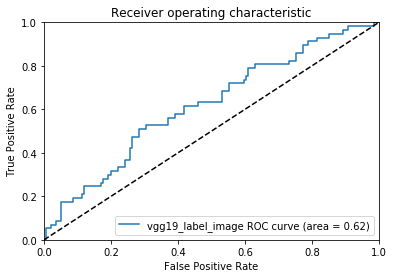

0.603878925972


In [20]:
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitvgg19_label_image.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='vgg19_label_image ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [34]:
# compute prediction for every images of every patient
# The get mean of probability for every patient(id)
def compute_prediction_2(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
#     x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # average probability
    print "predict after avg: "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.mean(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict avg:"
    df['cancer'] = pred_after
    return df

In [35]:
# save mean prediction info csv file
def save_results_2(df):
    df.to_csv(SUBMIT_OUTPUT_2, index=False)

In [36]:
# compute mean prediction for every patient id and save into submit_output_2 file
df = compute_prediction_2(clf)
print("Results:")
print df
df.head()
save_results_2(df)

length of df_2 198
Prediction took 10.420 sec.

pred before [ 0.4460575   0.3881403   0.38559099 ...,  0.51057611  0.46897289
  0.44677257]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after avg: 
finishing predict avg:
Results:
                                   id    cancer
0    026470d51482c93efc18b9803159c960  0.338130
1    031b7ec4fe96a3b035a8196264a8c8c3  0.271814
2    03bd22ed5858039af223c04993e9eb22  0.235724
3    06a90409e4fcea3e634748b967993531  0.299967
4    07b1defcfae5873ee1f03c90255eb170  0.256169
5    0b20184e0cd497028bdd155d9fb42dc9  0.267859
6    12db1ea8336eafaf7f9e3eda2b4e4fef  0.281190
7    159bc8821a2dc39a1e770cb3559e098d  0.256694
8    174c5f7c33ca31443208ef873b9477e5  0.229160
9    1753250dab5fc81bab8280df13309733  0.186348
10   1cf8e778167d20bf769669b4be96592b  0.206842
11   1e62be2c3b6430b78ce31a8f023531ac  0.291130
12   1f6333bc3599f683403d6f0884aefe00  0.273241
13   1fdbc07019192de4a114e090389c8330  0.277627
14   2

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.338130
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.271814
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.235724
3    06a90409e4fcea3e634748b967993531         0  Public  0.299967
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.256169
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.267859
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.281190
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.256694
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.229160
9    1753250dab5fc81bab8280df13309733         0  Public  0.186348
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.206842
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.291130
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.273241
13   1fdbc07019192de4a114e090389c8330         1  Pu

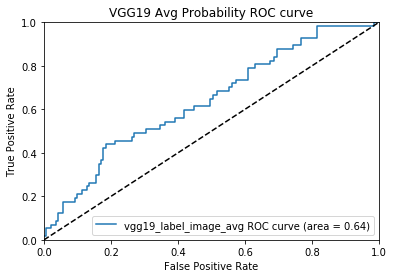

0.581748957901


In [47]:
# ROC curve for every patient using mean probability
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitvgg19_label_image_Avg.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='vgg19_label_image_avg ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('VGG19 Avg Probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [39]:
# compute prediction for every images of every patient
# The get max of probability for every patient(id)
def compute_prediction_3(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
    
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # average probability
    print "predict after avg: "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.max(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict max:"
    df['cancer'] = pred_after
    return df

In [40]:
# save max prediction for every patient id info csv file
def save_results_3(df):
    df.to_csv(SUBMIT_OUTPUT_3, index=False)

In [41]:
# compute max prediction for every patient id and save into submit_output_2 file
df = compute_prediction_3(clf)
print("Results:")
print df
df.head()
save_results_3(df)

length of df_2 198
Prediction took 10.460 sec.

pred before [ 0.4460575   0.3881403   0.38559099 ...,  0.51057611  0.46897289
  0.44677257]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after avg: 
finishing predict max:
Results:
                                   id    cancer
0    026470d51482c93efc18b9803159c960  0.528755
1    031b7ec4fe96a3b035a8196264a8c8c3  0.354972
2    03bd22ed5858039af223c04993e9eb22  0.351812
3    06a90409e4fcea3e634748b967993531  0.414811
4    07b1defcfae5873ee1f03c90255eb170  0.365509
5    0b20184e0cd497028bdd155d9fb42dc9  0.375592
6    12db1ea8336eafaf7f9e3eda2b4e4fef  0.395243
7    159bc8821a2dc39a1e770cb3559e098d  0.337789
8    174c5f7c33ca31443208ef873b9477e5  0.310288
9    1753250dab5fc81bab8280df13309733  0.276222
10   1cf8e778167d20bf769669b4be96592b  0.315321
11   1e62be2c3b6430b78ce31a8f023531ac  0.405230
12   1f6333bc3599f683403d6f0884aefe00  0.342004
13   1fdbc07019192de4a114e090389c8330  0.340371
14   2

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.528755
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.354972
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.351812
3    06a90409e4fcea3e634748b967993531         0  Public  0.414811
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.365509
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.375592
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.395243
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.337789
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.310288
9    1753250dab5fc81bab8280df13309733         0  Public  0.276222
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.315321
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.405230
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.342004
13   1fdbc07019192de4a114e090389c8330         1  Pu

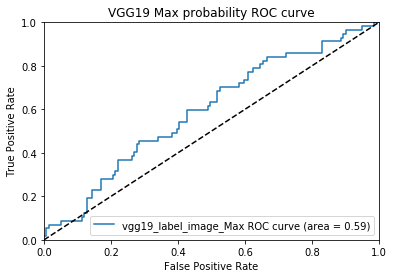

0.772827584253


In [48]:
# ROC curve for every patient using max probability
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitvgg19_label_image_Max.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='vgg19_label_image_Max ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('VGG19 Max probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [43]:
# compute prediction for every images of every patient
# The get min of probability for every patient(id)
def compute_prediction_4(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # average probability
    print "predict after avg: "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.min(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict min:", pred_after
    df['cancer'] = pred_after
    return df

In [44]:
# save min prediction for every patient id info csv file
def save_results_4(df):
    df.to_csv(SUBMIT_OUTPUT_4, index=False)

In [45]:
# compute min prediction for every patient id and save into submit_output_4 file
df = compute_prediction_4(clf)
print("Results:")
print df
df.head()
save_results_4(df)

length of df_2 198
Prediction took 10.450 sec.

pred before [ 0.4460575   0.3881403   0.38559099 ...,  0.51057611  0.46897289
  0.44677257]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after avg: 
finishing predict min: [0.16479648762451252, 0.19556814020415444, 0.16363459728114388, 0.19927153842250953, 0.17440922621953256, 0.18806430739528929, 0.2018712253399659, 0.15495999007937195, 0.17078599665488284, 0.13531332306694438, 0.1244922099384301, 0.20003726998490609, 0.19483382975125296, 0.22136933210472359, 0.17854672730112905, 0.17381505100584832, 0.14866463752140285, 0.16106507318384941, 0.13513828051073704, 0.19557604926521785, 0.56228795307443413, 0.13917061590014793, 0.20531126160868296, 0.18401468449835667, 0.18148779549853797, 0.10916475055479606, 0.15191527372377703, 0.18476379698160125, 0.17650175483170283, 0.16482152149808738, 0.20634922094894664, 0.21814980137691739, 0.16991806454176661, 0.20923350285940145, 0.15474929527096692, 0

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.164796
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.195568
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.163635
3    06a90409e4fcea3e634748b967993531         0  Public  0.199272
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.174409
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.188064
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.201871
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.154960
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.170786
9    1753250dab5fc81bab8280df13309733         0  Public  0.135313
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.124492
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.200037
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.194834
13   1fdbc07019192de4a114e090389c8330         1  Pu

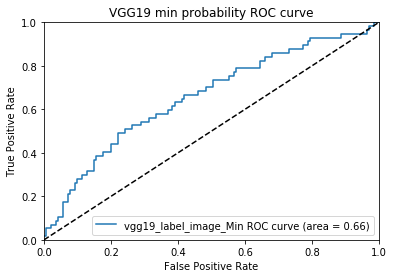

0.609184838158


In [49]:
# ROC curve for every patient using max probability
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc

print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitvgg19_label_image_Min.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='vgg19_label_image_Min ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('VGG19 min probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))
